# Recomendador
Dataset MovieLens -> https://grouplens.org/datasets/movielens/

Más info -> http://files.grouplens.org/datasets/movielens/ml-20m-README.html

Pearson Info -> https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/

#### Importación librerias necesarias

In [1]:
import pandas as pd
from random import randint
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import codecs, json
import pickle

## Carga de datos

In [2]:
small_data_path = "MovieLens/small/"

#### Peliculas
De las peliculas la información que nos interesa son los generos diferentes a los pueden pertenecer

In [3]:
movies = pd.read_csv(small_data_path + 'movies.csv')
movies.columns = ["movieid", "title", "genres"]
print("Contamos con un total de {} peliculas".format(len(movies)))

Contamos con un total de 27278 peliculas


In [4]:
movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Los diferentes generos posibles ya estan prefijados y son los siguientes

In [5]:
dif_genres = {"Action":0,"Adventure":1,"Animation":2,"Children":3,"Comedy":4,
           "Crime":5,"Documentary":6,"Drama":7,"Fantasy":8,"Film-Noir":9,"Horror":10,
           "Musical":11,"Mystery":12,"Romance":13,"Sci-Fi":14,"Thriller":15,"War":16,
           "Western":17,"(no genres listed)":18}

In [6]:
movieid_title = {}
for index, movie in movies.iterrows():
    movieid_title[int(movie["movieid"])] = movie["title"]

In [7]:
with open('movieid_title.txt', 'w') as outfile:
    json.dump(movieid_title, outfile)

#### Ratings
Contamos con ratings que van desde el 0.5 hasta el 5, donde cada usuario ha puntuado una serie de peliculas que ha creido oportunas y que pertenecen a un genero o generos en especifico.

In [8]:
ratings = pd.read_csv(small_data_path + 'ratings.csv')
ratings.columns = ["userid","movieid", "rating", "timestamp"]
print("Contamos con un total de {} ratings, de {} personas diferentes".format(len(ratings),len(ratings["userid"].unique())))

Contamos con un total de 20000263 ratings, de 138493 personas diferentes


In [9]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Podemos observar como las puntuaciones malas no son muy abundantes en los ratings

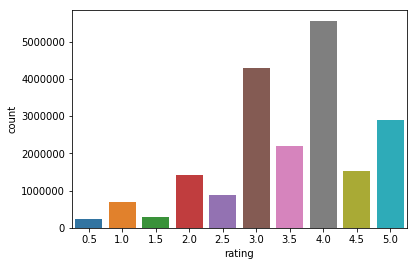

In [10]:
sns.countplot(ratings['rating'],label="Count")
plt.show()

#### Links
Quiero almacenar la referencia entre el movieid y su identificador en imdb para poder construir links a las peliculas

In [11]:
links = pd.read_csv(small_data_path + 'links.csv', converters={'imdbId': lambda x: str(x)})
links.columns = ["movieid","imdbid", "tmdbid"]

In [12]:
link_imdbid = {}
for index, link in links.iterrows():
    link_imdbid[int(link["movieid"])] = link["imdbid"]

In [13]:
with open('link_imdbid.txt', 'w') as outfile:
    json.dump(link_imdbid, outfile)

## Matriz de Preferencias

In [14]:
printed = -1
def print_progress(item, num_items, progress_step=1):
    global printed
    actual_progress = (item/num_items)*100
    if(actual_progress%progress_step==0 and printed!=actual_progress):
        printed = actual_progress
        print("Progress: {}%".format(actual_progress))

In [43]:
%%time
prefs_matrix = []
user_cont = 0
for user in ratings["userid"].unique():
    #print_progress(user_cont, len(ratings["userid"].unique()), progress_step=1)
    clear_output(wait=True)
    print("Usuario {} de {}.".format(user_cont, len(ratings["userid"].unique())))
    user_cont+=1
    this_prefs = [0]*(len(dif_genres)+2) # Vamos a llevar la suma de peliculas puntuadas y el id del usuario
    # Tomamos en primer lugar los ratings para el usuario que estamos extrayendo la info
    user_ratings = ratings.loc[ratings['userid'] == user]
    # Iteramos por cada rating de las peliculas del usuario para conocer los generos
    num_ratings = 0
    this_prefs[-1]=user
    for index, rating in user_ratings.iterrows():
        num_ratings+=1
        current_movie_genres = movies.loc[movies['movieid'] == rating["movieid"]][:].genres.values.item()
        current_movie_rating = float(rating["rating"].item())
        
        this_prefs[-2]=num_ratings
        # Dado los generos y el rating que les ha dado (provinientes de la pelicula)
        # Le asigno los valores correspondientes al perfil
        for a_genre in current_movie_genres.split("|"):
            if a_genre in dif_genres: # dif_genres es un diccionario que nos mapea entre genero e indice
                if current_movie_rating > 2.0:
                    this_prefs[dif_genres[a_genre]] += current_movie_rating
                else:
                    # Hacemos inversamente proporcional el ratin para que menor ratin reste mas!
                    this_prefs[dif_genres[a_genre]] -= 1.5/current_movie_rating
            else: # Hay algunos generos no 'identificados' como IMAX
                pass
    prefs_matrix.append(this_prefs)

Usuario 138492 de 138493.
Wall time: 10h 20min 29s


In [15]:
print("Para las puntuaciones negativas hemos decidido restar de forma inversamente proporcional:")
for i in [0.5,1.0,1.5,2.0]:
    print("\tPara {} restamos {}.".format(i, 1.5/i))

Para las puntuaciones negativas hemos decidido restar de forma inversamente proporcional:
	Para 0.5 restamos 3.0.
	Para 1.0 restamos 1.5.
	Para 1.5 restamos 1.0.
	Para 2.0 restamos 0.75.


In [45]:
np_prefs = np.array(prefs_matrix)

In [46]:
np_prefs.shape

(138493, 21)

In [47]:
np.save("user_prefs.npy", np_prefs)

In [16]:
np_prefs = np.load("user_prefs.npy")

In [17]:
np_prefs.shape

(138493, 21)

### Normalización

In [18]:
prefs_matrix = np_prefs[:,:-2]
films_seen = np_prefs[:,-2:-1]
users_vector = np_prefs[:,-1:]

In [19]:
prefs_sum = np.sum(prefs_matrix, axis=1)

In [28]:
prefs_normalized = prefs_matrix/prefs_sum.reshape(-1,1)

In [35]:
prefs_normalized_dict = {}
for index, curr_pref in enumerate(prefs_normalized):
    prefs_normalized_dict[index] = curr_pref.tolist()

In [37]:
with open('user_prefs.txt', 'w') as outfile:
    json.dump(prefs_normalized_dict, outfile)

In [38]:
len(prefs_normalized_dict)

138493

### Pearson Correlation

In [21]:
from scipy.stats.stats import pearsonr
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

In [22]:
def calculate_pearson_neighbour(data_matrix, user, num_neighbours=1):
    """
    Calcula los 'num_neighbours' de mayor coeficiente de correlacion
    pearson entre una base de datos de usuario 'data_matrix' y las 
    preferencias de un usuario dado 'user' y devolvemos los id de los usuarios
    con mayor coeficiente
    """
    max_correlation = [-2]*num_neighbours # Recordar que los coeficientes van de -1 a +1
    user_indx = [-1]*num_neighbours
    for indx, curr_user in enumerate(data_matrix):
        curr_pearson = pearsonr(curr_user, user)[0]
        
        if max_correlation[0] < curr_pearson:
            max_correlation[0] = curr_pearson
            user_indx[0] = indx
            # Ordenamos los array en funcion de los valores de correlacion
            # para que siempre quitemos la correlacion de menor valor
            user_indx = np.array(user_indx)[np.argsort(max_correlation).tolist()].tolist()
            max_correlation.sort()

    #print(max_correlation)
    #print(data_matrix[user_indx])
    return user_indx

In [23]:
def find_top_user_movies(userid, movie_umbral=4.0, num_movies=5):
    """
    Dado el id de un usuario, devolvemos las primeras 'num_movies' ordenadas
    por rating de mayor a menor siempre que superen cierto umbral 'umbral_movie'
    """
    best_ratings = ratings.loc[(ratings['userid'] == userid) & (ratings["rating"]>movie_umbral)]
    best_ratings = best_ratings.sort_values("rating", ascending=False)
    result = []
    for indx, row in best_ratings.sort_values("rating", ascending=False).iterrows():
        result.append(int(row["movieid"]))
        if len(result)==num_movies: break
    return result

In [24]:
def all_movies(userid):
    """
    Dado un id de usuario devolvemos todas las peliculas vistas por 
    dicho usuario
    """
    return find_top_user_movies(userid, movie_umbral=-1.0, num_movies=999999999)

In [25]:
def movies_intersection(movies_seen, list_movies):
    """
    Dada una lista de peliculas que he visto y una lista de peliculas,
    devolvemos las peliculas de la lista de peliculas que no estan entre 
    las que hemos visto -> https://stackoverflow.com/a/7961390
    """
    return list(set(list_movies) - set(movies_seen))

In [26]:
def recommend_movies(matrix_users, user_prefs, user_movies, num_movies, num_neighbours=1):
    """
    Dada las preferencias de un usuario con respecto a los diferentes
    generos y una matriz con los perfiles de los diferentes usuarios
    con sus preferencias, tomamos los N primeros usuarios con respecto
    al coeficiente de Pearson y de ellos sacamos sus peliculas mejor puntuadas
    para finalmente devolver las que nuestro usuario no ha visto
    """
    neighbours = calculate_pearson_neighbour(matrix_users, user_prefs, num_neighbours=num_neighbours)
    possible_movies = []
    for neighbour in neighbours:
        possible_movies.extend(find_top_user_movies(neighbour,num_movies=999))
    return movies_intersection(user_movies, possible_movies)[0:num_movies]

Con esto ya somos capaces de realizar pruebas para recomendar peliculas a usuarios

In [27]:
recommend_movies(prefs_normalized[2:,:], prefs_normalized[1], all_movies(1), num_movies=10, num_neighbours=10)

[1, 69122, 33794, 1033, 2058, 91658, 2571, 11, 527, 17]

### Consideraciones prácticas para implementación web

Exportamos la matriz de datos normalizados como json para poder leerlo con Javascript en la web

In [82]:
b = prefs_normalized.tolist() # nested lists with same data, indices
file_path = "user_prefs.json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

Para tratar facilmente la búsqueda de peliculas por usuario vamos a crear un array con usuarios y un alista con su pelicula visualziada (movieid) y el rating que le ha puesto

In [28]:
def intercala_listas(a, b):
    c = list(zip(a, b))
    return [elt for sublist in c for elt in sublist]

In [30]:
%%time
user_cont=0
movie_umbral = 4.0
best_ratings = {}

for user in ratings["userid"].unique():
    current_ratings = ratings.loc[ratings['userid'] == user]
    movie_ids = current_ratings["movieid"].tolist()
    movie_ratings = current_ratings["rating"].tolist()
    best_ratings[user] = intercala_listas(movie_ids,movie_ratings)
    
    clear_output(wait=True)
    print("Usuario {} de {}.".format(user_cont, len(ratings["userid"].unique())))
    user_cont+=1

Usuario 138492 de 138493.
CPU times: user 3h 56min 46s, sys: 44min 6s, total: 4h 40min 52s
Wall time: 4h 39min 55s


In [31]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [22]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [33]:
save_obj(best_ratings, "ratings_users")

In [27]:
best_ratings = load_obj("ratings_users")

In [25]:
best_ratings = {str(k):v for k,v in best_ratings.items()}

In [26]:
with open('ratings_users.txt', 'w') as outfile:
    json.dump(best_ratings, outfile)